# Acceleration as a function of Time on Equator

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from astropy import units as u
from astropy import constants as c
from itertools import product
import yssbtmpy as tm

from matplotlib import pyplot as plt
from matplotlib import rcParams

from accutil import (set_perpmodel, set_phaethon, set_model_aspect,
                     linticker, logxticker, logyticker, CHEMDICT,
                    QprbarSpline, QprbarSunSpline, QPRDIR)

FIGDIR = Path("./figs")

TPM_PERP = dict(rot_period=6*u.h, 
                r_hel=0.2*u.au,
                a_bond=0.1, 
                ti=200, 
                bulk_mass_den=2000*u.kg/u.m**3, 
                emissivity=0.90,
                nlon=360,
                nlat=3)

In [3]:
# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
rcParams.update({'font.size':12})

## Combined

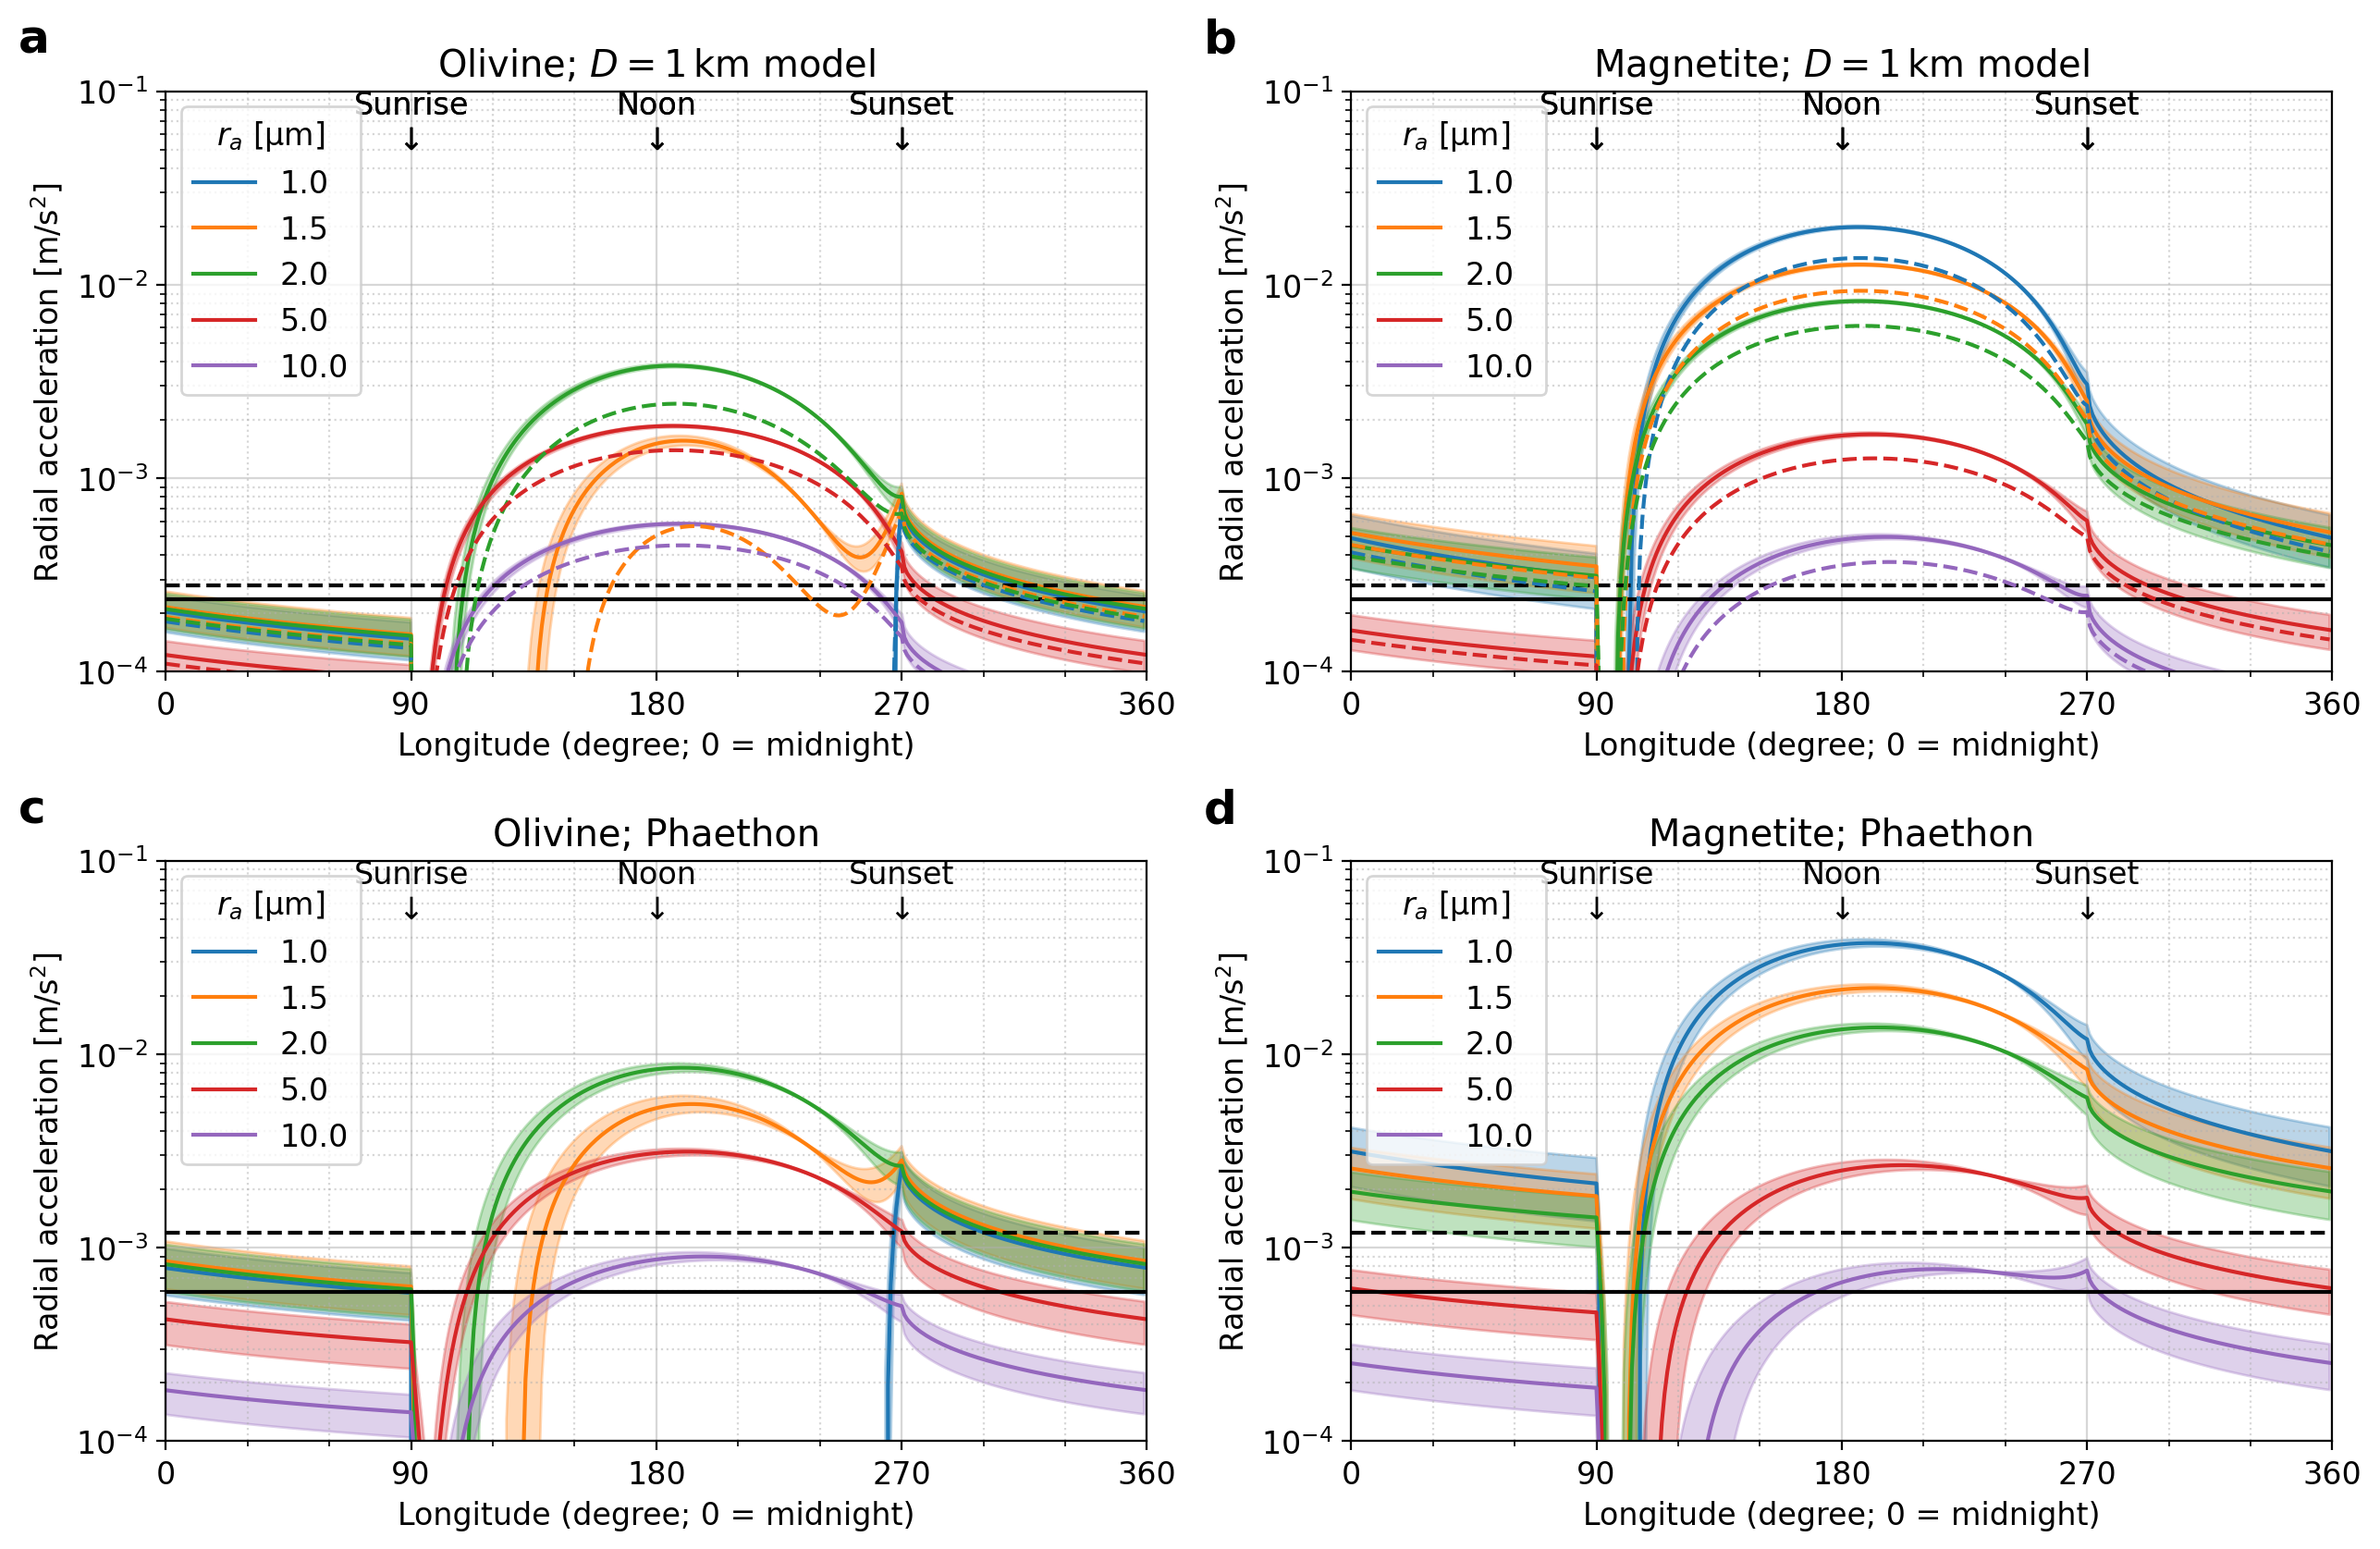

In [4]:
TPM_PERP = dict(rot_period=6*u.h, 
                r_hel=0.2*u.au,
                a_bond=0.1, 
                ti=200, 
                bulk_mass_den=2000*u.kg/u.m**3, 
                emissivity=0.90,
                nlon=360,
                nlat=3)

perpmodel = set_perpmodel(diam_eff=1*u.km, **TPM_PERP)
th45model = set_model_aspect(diam_eff=1*u.km, **TPM_PERP, aspect_deg=45)
phaemodel = set_phaethon(true_anom=0)
perpmodel.calc_temp(full=False)
phaemodel.calc_temp(full=False)

def setting_ax(ax):
    linticker(ax, 
             xmajlockws=90, xminlockws=30,
             ymajlockws=1, yminlockws=1,
             xmajfmtkws="%.0f",
             ymajfmtkws="",
             )
    ax.set(ylim=(1.e-4, 1.e-1), 
           xlim=(0, 360),
           yscale='log',
           xlabel="Longitude (degree; 0 = midnight)",
           ylabel=r"Radial acceleration [$\mathrm{m/s^2}$]"
          )
    ax.text(90, 0.05, "Sunrise\n↓", horizontalalignment='center')
    ax.text(180, 0.05, "Noon\n↓", horizontalalignment='center')
    ax.text(270, 0.05, "Sunset\n↓", horizontalalignment='center')
    ax.legend(title="$r_a$ [µm]", loc='upper left')
    
    
# dphi, a_grav, a_cent are identical for perp and th45 models.
dphi = np.rad2deg(phaemodel.dlon)
phis = np.arange(0, 360 - dphi/2, dphi)

a_grav = (tm.GG_Q * perpmodel.mass / (perpmodel.diam_eff/2)**2).to(u.m/u.s**2)
a_cent = perpmodel.rot_omega**2*perpmodel.diam_eff/2

lss = ['-', '--']
tis = {0:[200, 150, 250], 1:[200]}

fig, axs = plt.subplots(2, 2, figsize=(13, 8.5))

for i_ax, (chem, chemname) in enumerate(CHEMDICT.items()):
    Qprbar_sun = QprbarSunSpline(QPRDIR/f"Qprbar_sun_{chem}.csv")
    Qprbar_ther = QprbarSpline(QPRDIR/f"Qprbar_{chem}.csv")

    for i_m, model in enumerate([perpmodel, th45model]):
        ax = axs[0][i_ax]
        detail = len(tis[i_m]) > 1

        for i_r, radius in enumerate([1, 1.5, 2, 5, 10]):
            color = plt.cm.tab10(i_r)
            a_sun_r = np.zeros((phis.shape[0], 3), dtype=float)
            a_ref_r = np.zeros((phis.shape[0], 3), dtype=float)
            a_ther_r = np.zeros((phis.shape[0], 3), dtype=float)

            for i, ti in enumerate(tis[i_m]):
                model.set_thermal(ti=ti, emissivity=TPM_PERP["emissivity"])
                model.calc_temp()
                particle = tm.MovingParticle(smallbody=model,
                                             radius=radius*u.um,
                                             mass_den=3000*u.kg/u.m**3)
                particle.set_func_Qprbar(func_Qprbar=Qprbar_ther.get_value,
                                         func_Qprbar_sun=Qprbar_sun.get_value)

                for j, phi in enumerate(phis):
                    particle.set_initial_pos(90, phi, height=1*u.cm)
                    r_unit = particle.trace_rvec[0]
                    a_sun_r[j, i] = np.dot(r_unit, particle.trace_a_sun_xyz[0])
                    a_ref_r[j, i] = np.dot(r_unit, particle.trace_a_ref_xyz[0])
                    a_ther_r[j, i] = np.dot(r_unit, particle.trace_a_ther_xyz[0])

            a_sum = a_ther_r + a_ref_r + a_sun_r
            a_min = a_sum.min(axis=1)
            a_max = a_sum.max(axis=1)

            if detail:
                ax.fill_between(phis, a_min, a_max, color=color, alpha=0.3)
                label = "{:.1f}".format(radius)
            else:
                label = None
            ax.plot(phis, a_sum[:, 0], color=color, ls=lss[i_m], label=label)

        if detail:
#             ax.axhline(a_grav.value, color='k', ls='--', label="Grav")
#             ax.axhline((a_grav - a_cent).value, color='k', ls='-', label="Grav - Cent")
            ax.axhline(a_grav.value, color='k', ls='--')
            ax.axhline((a_grav - a_cent).value, color='k', ls='-')

        setting_ax(ax)
        
a_grav = (tm.GG_Q * phaemodel.mass / (phaemodel.diam_eff/2)**2).to(u.m/u.s**2)
a_cent = phaemodel.rot_omega**2*phaemodel.diam_eff/2

lss = ['-', '--']
tis = {0:[600, 400, 800], 1:[600]}

for i_ax, (chem, chemname) in enumerate(CHEMDICT.items()):
    Qprbar_sun = QprbarSunSpline(QPRDIR/f"Qprbar_sun_{chem}.csv")
    Qprbar_ther = QprbarSpline(QPRDIR/f"Qprbar_{chem}.csv")

    for i_m, model in enumerate([phaemodel]):
        ax = axs[1][i_ax]
        detail = len(tis[i_m]) > 1

        for i_r, radius in enumerate([1, 1.5, 2, 5, 10]):
            color = plt.cm.tab10(i_r)
            a_sun_r = np.zeros((phis.shape[0], 3), dtype=float)
            a_ref_r = np.zeros((phis.shape[0], 3), dtype=float)
            a_ther_r = np.zeros((phis.shape[0], 3), dtype=float)

            for i, ti in enumerate(tis[i_m]):
                model.set_thermal(ti=ti, emissivity=TPM_PERP["emissivity"])
                model.calc_temp()
                particle = tm.MovingParticle(smallbody=model,
                                             radius=radius*u.um,
                                             mass_den=3000*u.kg/u.m**3)
                particle.set_func_Qprbar(func_Qprbar=Qprbar_ther.get_value,
                                         func_Qprbar_sun=Qprbar_sun.get_value)

                for j, phi in enumerate(phis):
                    particle.set_initial_pos(90, phi, height=1*u.cm)
                    r_unit = particle.trace_rvec[0]
                    a_sun_r[j, i] = np.dot(r_unit, particle.trace_a_sun_xyz[0])
                    a_ref_r[j, i] = np.dot(r_unit, particle.trace_a_ref_xyz[0])
                    a_ther_r[j, i] = np.dot(r_unit, particle.trace_a_ther_xyz[0])

            a_sum = a_ther_r + a_ref_r + a_sun_r
            a_min = a_sum.min(axis=1)
            a_max = a_sum.max(axis=1)

            if detail:
                ax.fill_between(phis, a_min, a_max, color=color, alpha=0.3)
                label = r"{:.1f}".format(radius)
            else:
                label = None
            ax.plot(phis, a_sum[:, 0], color=color, ls=lss[i_m], label=label)

        if detail:
#             ax.axhline(a_grav.value, color='k', ls='--', label="Grav")
#             ax.axhline((a_grav - a_cent).value, color='k', ls='-', label="Grav - Cent")
            ax.axhline(a_grav.value, color='k', ls='--')
            ax.axhline((a_grav - a_cent).value, color='k', ls='-')

        setting_ax(ax)
        
axs[0][0].set(title="Olivine; $D = 1\,\mathrm{{km}}$ model")
axs[1][0].set(title=f"Olivine; Phaethon")
axs[0][1].set(title="Magnetite; $D = 1\,\mathrm{{km}}$ model")
axs[1][1].set(title="Magnetite; Phaethon")

for i, ax in enumerate(axs.flatten()):
    ax.text(x=-0.15, y=1.05, s=chr(ord('a') + i), transform=ax.transAxes, 
            fontsize=18, fontweight='bold', va='bottom', ha='left')

plt.tight_layout()
plt.savefig(FIGDIR / f"acc_diagram-all.png", dpi=300)
plt.savefig(FIGDIR / f"acc_diagram-all.pdf")
plt.show()

## Separated
Model and Phaethon equatorial accelerations

In [5]:
perpmodel = set_perpmodel(diam_eff=1*u.km, **TPM_PERP)
th45model = set_model_aspect(diam_eff=1*u.km, **TPM_PERP, aspect_deg=45)
phaemodel = set_phaethon(true_anom=0)
perpmodel.calc_temp(full=False)
phaemodel.calc_temp(full=False)

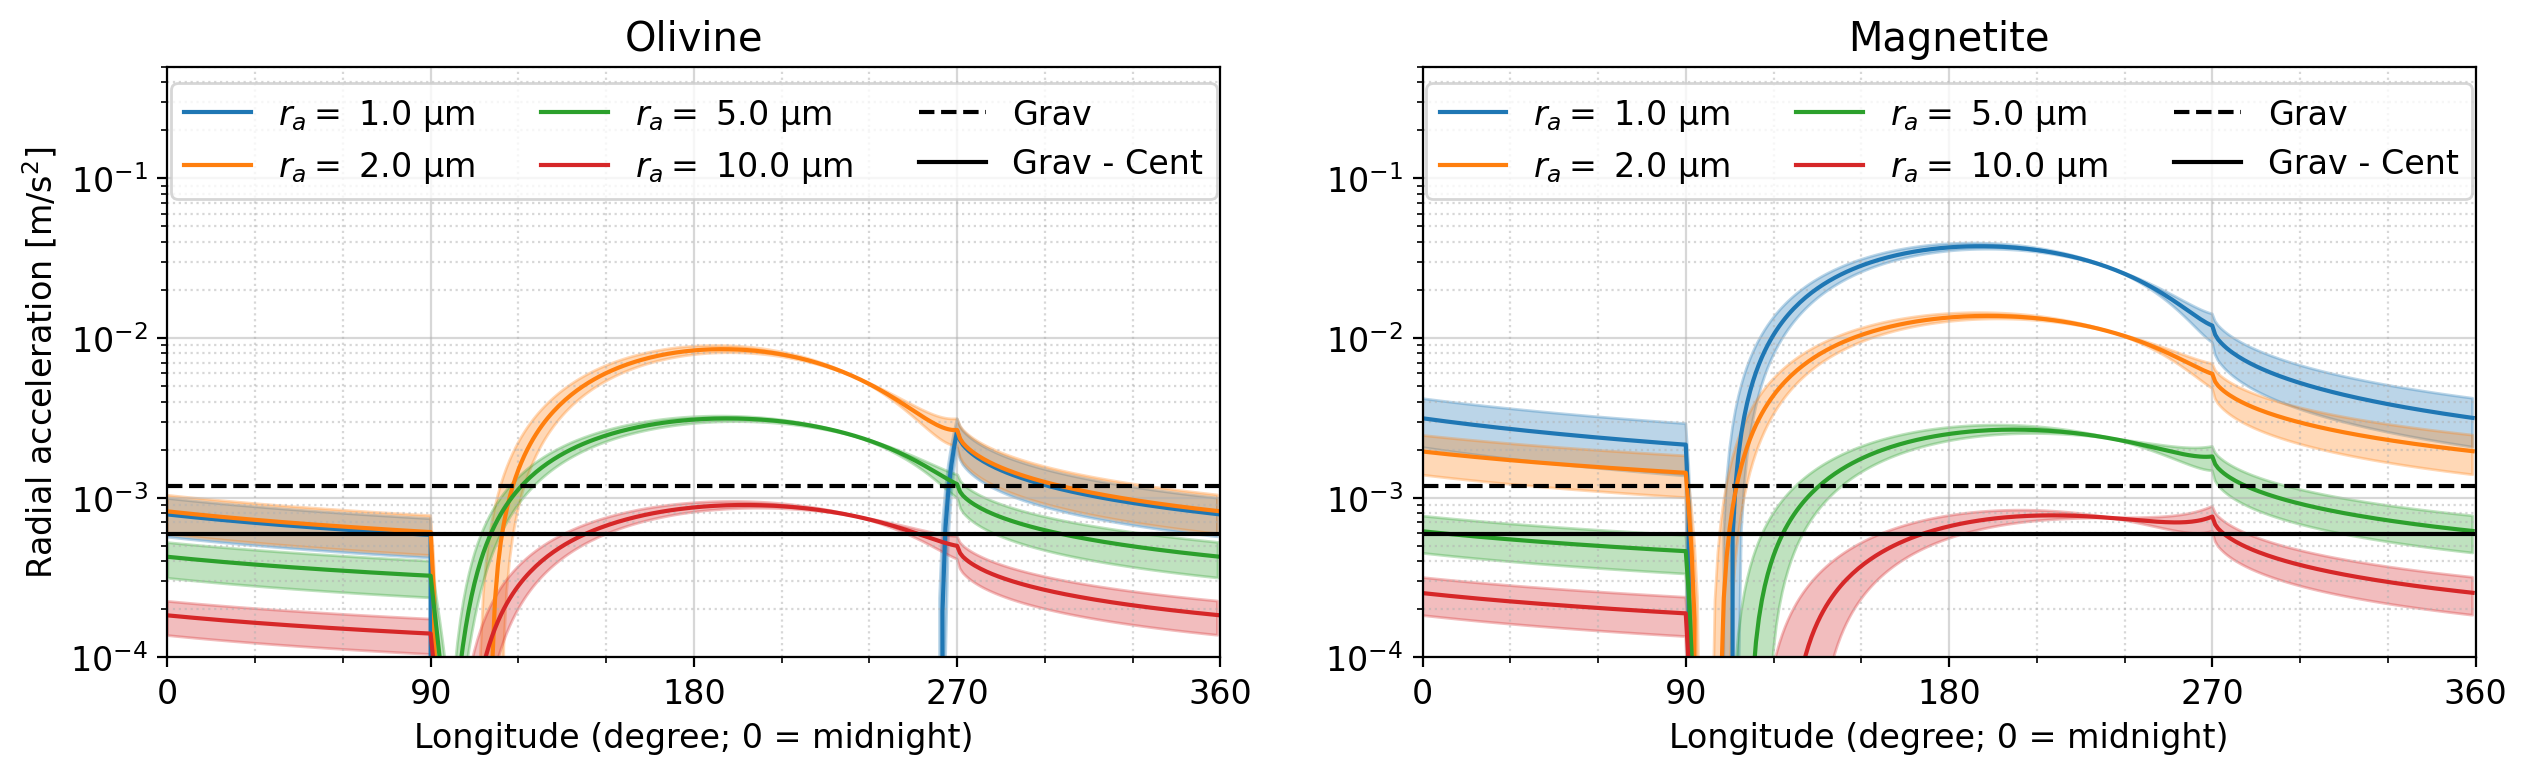

In [6]:
# dphi, a_grav, a_cent are identical for perp and th45 models.
dphi = np.rad2deg(phaemodel.dlon)
phis = np.arange(0, 360 - dphi/2, dphi)

a_grav = (tm.GG_Q * phaemodel.mass / (phaemodel.diam_eff/2)**2).to(u.m/u.s**2)
a_cent = phaemodel.rot_omega**2*phaemodel.diam_eff/2

lss = ['-', ':']
tis = {0:[600, 400, 800], 1:[600]}

fig, axs = plt.subplots(1, 2, figsize=(13, 4.))

for i_ax, (chem, chemname) in enumerate(CHEMDICT.items()):
    Qprbar_sun = QprbarSunSpline(QPRDIR/f"Qprbar_sun_{chem}.csv")
    Qprbar_ther = QprbarSpline(QPRDIR/f"Qprbar_{chem}.csv")

    for i_m, model in enumerate([phaemodel]):
        ax = axs[i_ax]
        detail = len(tis[i_m]) > 1

        for i_r, radius in enumerate([1, 2, 5, 10]):
            color = plt.cm.tab10(i_r)
            a_sun_r = np.zeros((phis.shape[0], 3), dtype=float)
            a_ref_r = np.zeros((phis.shape[0], 3), dtype=float)
            a_ther_r = np.zeros((phis.shape[0], 3), dtype=float)

            for i, ti in enumerate(tis[i_m]):
                model.set_thermal(ti=ti, emissivity=TPM_PERP["emissivity"])
                model.calc_temp()
                particle = tm.MovingParticle(smallbody=model,
                                             radius=radius*u.um,
                                             mass_den=3000*u.kg/u.m**3)
                particle.set_func_Qprbar(func_Qprbar=Qprbar_ther.get_value,
                                         func_Qprbar_sun=Qprbar_sun.get_value)

                for j, phi in enumerate(phis):
                    particle.set_initial_pos(90, phi, height=1*u.cm)
                    r_unit = particle.trace_rvec[0]
                    a_sun_r[j, i] = np.dot(r_unit, particle.trace_a_sun_xyz[0])
                    a_ref_r[j, i] = np.dot(r_unit, particle.trace_a_ref_xyz[0])
                    a_ther_r[j, i] = np.dot(r_unit, particle.trace_a_ther_xyz[0])

            a_sum = a_ther_r + a_ref_r + a_sun_r
            a_min = a_sum.min(axis=1)
            a_max = a_sum.max(axis=1)

            if detail:
                ax.fill_between(phis, a_min, a_max, color=color, alpha=0.3)
                label = r"$r_a =$ {:.1f} µm".format(radius)
            else:
                label = None
            ax.plot(phis, a_sum[:, 0], color=color, ls=lss[i_m], label=label)

        if detail:
            ax.axhline(a_grav.value, color='k', ls='--', label="Grav")
            ax.axhline((a_grav - a_cent).value, color='k', ls='-', label="Grav - Cent")

        linticker(ax, 
                 xmajlockws=90, xminlockws=30,
                 ymajlockws=1, yminlockws=1,
                 xmajfmtkws="%.0f",
                 ymajfmtkws="",
                 )
        ax.set(ylim=(1.e-4, 5.e-1), 
                xlim=(0, 360),
                yscale='log')
        ax.legend(loc='upper center', ncol=3)
        
axs[0].set(xlabel="Longitude (degree; 0 = midnight)",
           ylabel=r"Radial acceleration [$\mathrm{m/s^2}$]",
          title=f"Olivine")
axs[1].set(xlabel="Longitude (degree; 0 = midnight)", title="Magnetite")

plt.tight_layout()
plt.savefig(FIGDIR / f"phae_acc_diagram.png", dpi=300)
plt.savefig(FIGDIR / f"phae_acc_diagram.pdf")
plt.show()

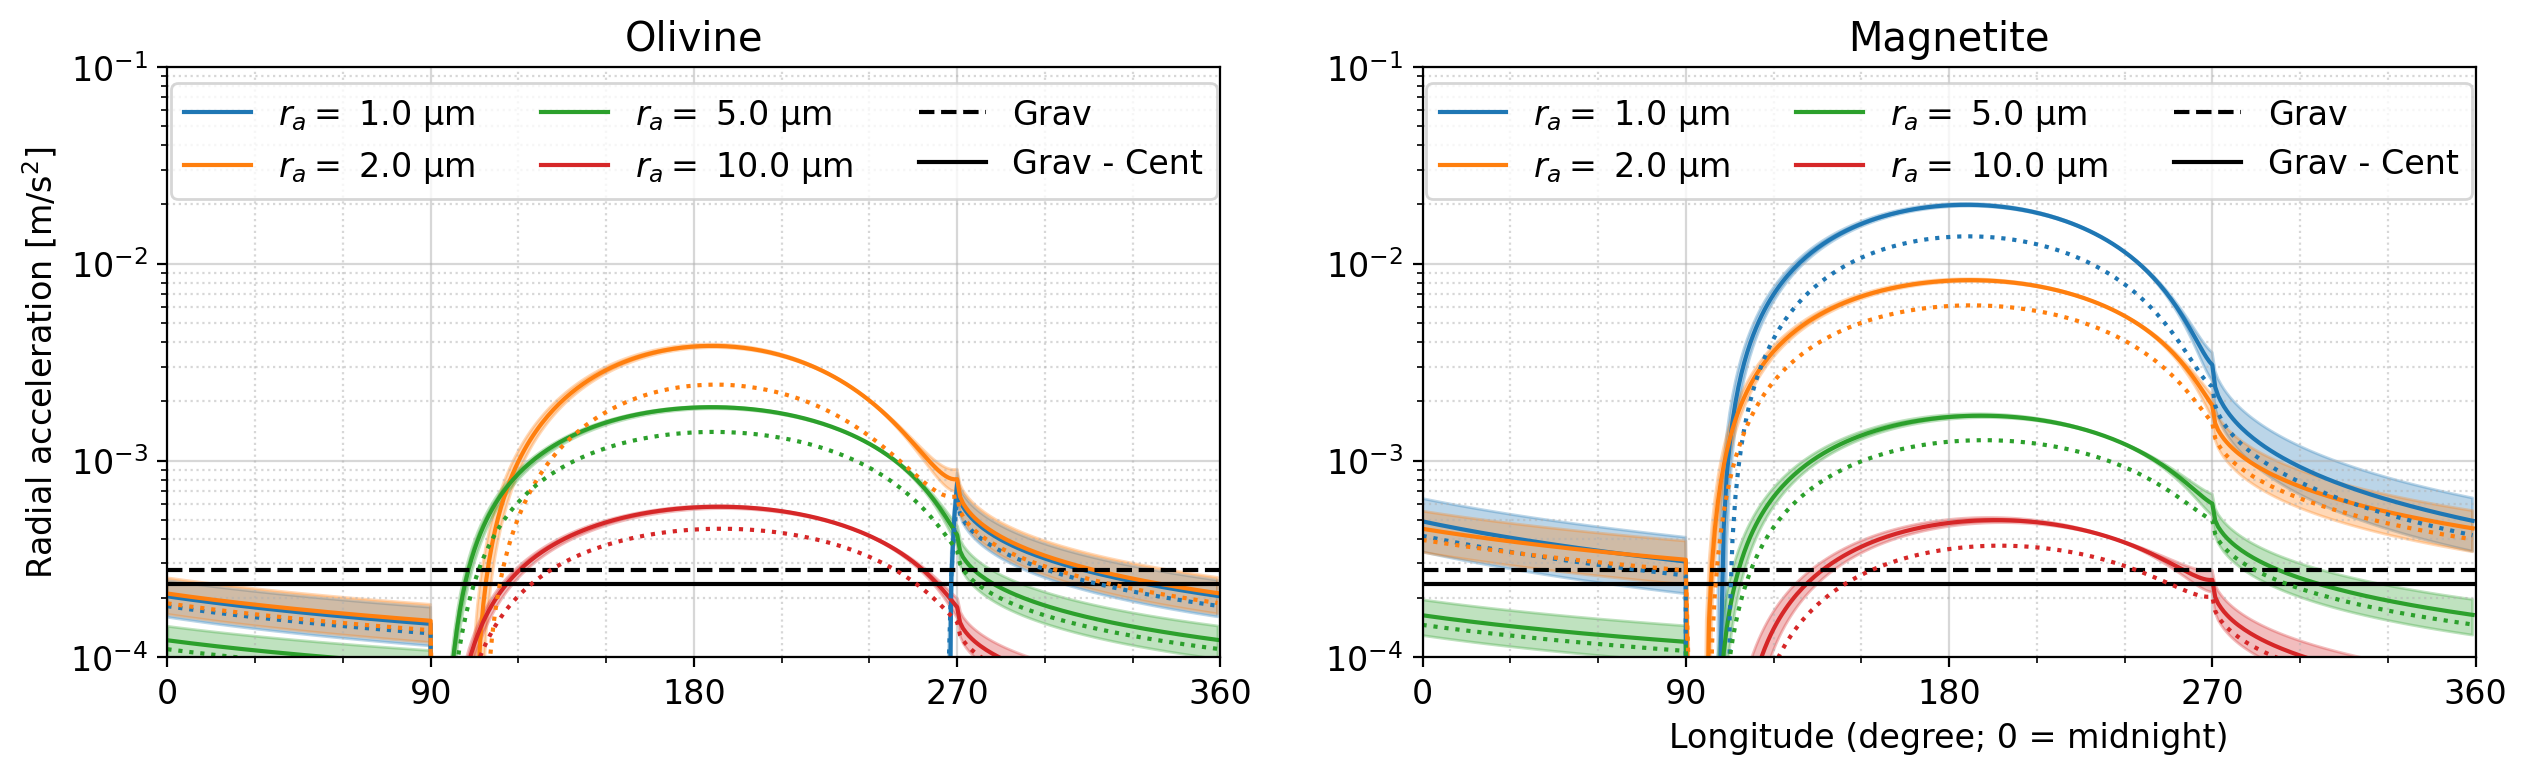

In [7]:
# dphi, a_grav, a_cent are identical for perp and th45 models.
dphi = np.rad2deg(perpmodel.dlon)
phis = np.arange(0, 360 - dphi/2, dphi)

a_grav = (tm.GG_Q * perpmodel.mass / (perpmodel.diam_eff/2)**2).to(u.m/u.s**2)
a_cent = perpmodel.rot_omega**2*perpmodel.diam_eff/2

lss = ['-', ':']
tis = {0:[200, 150, 250], 1:[200]}

fig, axs = plt.subplots(1, 2, figsize=(13, 4.))

for i_ax, (chem, chemname) in enumerate(CHEMDICT.items()):
    Qprbar_sun = QprbarSunSpline(QPRDIR/f"Qprbar_sun_{chem}.csv")
    Qprbar_ther = QprbarSpline(QPRDIR/f"Qprbar_{chem}.csv")

    for i_m, model in enumerate([perpmodel, th45model]):
        ax = axs[i_ax]
        detail = len(tis[i_m]) > 1

        for i_r, radius in enumerate([1, 2, 5, 10]):
            color = plt.cm.tab10(i_r)
            a_sun_r = np.zeros((phis.shape[0], 3), dtype=float)
            a_ref_r = np.zeros((phis.shape[0], 3), dtype=float)
            a_ther_r = np.zeros((phis.shape[0], 3), dtype=float)

            for i, ti in enumerate(tis[i_m]):
                model.set_thermal(ti=ti, emissivity=TPM_PERP["emissivity"])
                model.calc_temp()
                particle = tm.MovingParticle(smallbody=model,
                                             radius=radius*u.um,
                                             mass_den=3000*u.kg/u.m**3)
                particle.set_func_Qprbar(func_Qprbar=Qprbar_ther.get_value,
                                         func_Qprbar_sun=Qprbar_sun.get_value)

                for j, phi in enumerate(phis):
                    particle.set_initial_pos(90, phi, height=1*u.cm)
                    r_unit = particle.trace_rvec[0]
                    a_sun_r[j, i] = np.dot(r_unit, particle.trace_a_sun_xyz[0])
                    a_ref_r[j, i] = np.dot(r_unit, particle.trace_a_ref_xyz[0])
                    a_ther_r[j, i] = np.dot(r_unit, particle.trace_a_ther_xyz[0])

            a_sum = a_ther_r + a_ref_r + a_sun_r
            a_min = a_sum.min(axis=1)
            a_max = a_sum.max(axis=1)

            if detail:
                ax.fill_between(phis, a_min, a_max, color=color, alpha=0.3)
                label = r"$r_a =$ {:.1f} µm".format(radius)
            else:
                label = None
            ax.plot(phis, a_sum[:, 0], color=color, ls=lss[i_m], label=label)

        if detail:
            ax.axhline(a_grav.value, color='k', ls='--', label="Grav")
            ax.axhline((a_grav - a_cent).value, color='k', ls='-', label="Grav - Cent")

        linticker(ax, 
                 xmajlockws=90, xminlockws=30,
                 ymajlockws=1, yminlockws=1,
                 xmajfmtkws="%.0f",
                 ymajfmtkws="",
                 )
        ax.set(ylim=(1.e-4, 1.e-1), 
                xlim=(0, 360),
                yscale='log')
        ax.legend(loc='upper center', ncol=3)
        
axs[0].set(ylabel=r"Radial acceleration [$\mathrm{m/s^2}$]",
              title=f"Olivine")
axs[1].set(xlabel="Longitude (degree; 0 = midnight)", title="Magnetite")

plt.tight_layout()
plt.savefig(FIGDIR / f"perp_acc_diagram.png", dpi=300)
plt.savefig(FIGDIR / f"perp_acc_diagram.pdf")
plt.show()